# Hey Germany - Is Corona finaly over?

## Topic Description

This notebook contains data evaluations for the follwing medium article:

--> LinkToArticle

Since it looks like that in Germany everything get to normal slowly, I want to recap both the course of the Corona cases and vaccinations in Germany during the whole Corona lifecircle. 

At the end we want to be able to answer the following questions with the data:

1. **Which were the worst times for Germany during Corona?**
2. **How did the virus hit Germany in total?**
3. **How is vaccination progressing in Germany?**
4. **Which vaccines are preferred in Germany?**
5. **How many cases will we have at the end of July?**

## The Data 

The data we use for the course of the Corona Cases and the vaccination numbers comes from Kaggle. Credits go to person who prepares the data on Kaggle and keeps them updated every day!
You can get the data by using the folloing link:

--> https://www.kaggle.com/headsortails/covid19-tracking-germany

* Corona data: covid_de.csv
* Vaccination data: covid_de_vaccines.csv
* demographics data: demographics_de.csv


# import libraries

In [510]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import data

In [511]:
# the data comes from Kaggle. You can find it by using the following link:
# https://www.kaggle.com/headsortails/covid19-tracking-germany

df_cov = pd.read_csv("data/covid_de.csv", parse_dates=["date"])
df_vac = pd.read_csv("data/covid_de_vaccines.csv")
df_demo = pd.read_csv("data/demographics_de.csv")

# get current population of Germany

In [512]:
# get current german population 
import requests
from bs4 import BeautifulSoup
page = requests.get("https://www.destatis.de/EN/Themes/Society-Environment/Population/Current-Population/_node.html")
page

soup = BeautifulSoup(page.content, 'html.parser')

element = soup.find_all(title='Population by sex and citizenship')[0].text

pop_ger = float(repr(element.split("\n")[1]).split("\\")[0].split("'")[1].replace(",", "."))*1000000

print(f"The current population of Germany is {pop_ger}")

The current population of Germany is 83100000.0


# describe data

In [618]:
def get_some_information(df):
    """This function gives you basic information about your dataset. 
    By passing in a dataframe, you will get the following information:
    - The shape of you dataset [rows,columns]
    - The number of missing values by column
    - The datatypes of your columns
    
    parameters:
    df: Pass in a pandas dataframe"""
    # shape
    rows,cols = df.shape[0], df.shape[1]
    print(f"This dataset has {rows} rows and {cols} columns")
    
    # missing values
    missing = df.isna().sum().to_dict()
    for k,v in missing.items():
        if v != 0:
            print(f"The column {k} has {v} missing values")
            
    # datatypes
    types = df.dtypes.to_dict()
    integers, objects = [],[]
    for k,v in types.items():
        if v == np.dtype('O'):
            objects.append(k)
        elif v == np.dtype("int"):
            integers.append(k)
        else:
            print(f"Column {k} is a {v} type and didn't got categorized in our lists")
            
    print(f"The following columns are objects: {objects}")
    print(f"The following columns are integers: {integers}")
            

# German Covid Data

In [514]:
get_some_information(df_cov)

This dataset has 869446 rows and 8 columns
The column age_group has 2169 missing values
The column gender has 16366 missing values
Column date is a datetime64[ns] type and didn't got categorized in our lists
The following columns are objects: ['state', 'county', 'age_group', 'gender']
The following columns are integers: ['cases', 'deaths', 'recovered']


# Vaccine Data

In [515]:
get_some_information(df_vac)

This dataset has 167 rows and 9 columns
The following columns are objects: ['date']
The following columns are integers: ['doses', 'doses_first', 'doses_second', 'pfizer_cumul', 'moderna_cumul', 'astrazeneca_cumul', 'persons_first_cumul', 'persons_full_cumul']


# Demographic Data

In [516]:
get_some_information(df_demo)

This dataset has 192 rows and 4 columns
The following columns are objects: ['state', 'gender', 'age_group']
The following columns are integers: ['population']


# Let's check the correlations for the features Gender and Age_Group

In [517]:
# replace with numeric values for correlation analysis
df_cov.head()
df_corr = df_cov.copy()
replace_ages = {'35-59':3, '15-34':2, '60-79':4, '05-14':1, '80-99':5, '00-04':0}
replace_gender = {"F":1, "M":2}

In [518]:
df_corr["age_group"] = df_corr["age_group"].replace(replace_ages)

In [519]:
df_corr["gender"] = df_corr["gender"].replace(replace_gender)

In [520]:
df_corr_matrix = df_corr.corr()

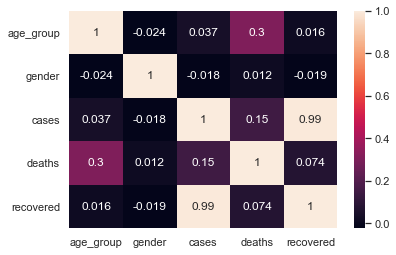

In [521]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(df_corr_matrix,annot=True)

### Interpretation

* Positive Correlation between AgeGroup and Deaths
* No significant Correlation between Gender and the other features

# 1. Which were the worst times for Germany during Corona?
# &
# 2. How did the virus hit Germany in total?

In [522]:
# get month feature out of date
df_cov["month"] = df_cov["date"].dt.to_period("m").astype(str)
df_cov['month'] = pd.to_datetime(df_cov['month'])

In [523]:
df_cov_states = df_cov[["state", "cases", "deaths", "recovered", "month"]].groupby(["state", "month"]).sum().reset_index()

In [524]:
# caluate the ration of infected died and infected recovered
df_cov_states["infected_died"] = df_cov_states.deaths/df_cov_states.cases*100
df_cov_states["infected_recovered"] = df_cov_states.recovered/df_cov_states.cases*100

In [525]:
df_cov_states

,state,month,cases,deaths,recovered,infected_died,infected_recovered
0,Baden-Wuerttemberg,2020-01-01,1,0,1,0.000000,100.000000
1,Baden-Wuerttemberg,2020-02-01,19,0,19,0.000000,100.000000
2,Baden-Wuerttemberg,2020-03-01,15266,637,14629,4.172671,95.827329
3,Baden-Wuerttemberg,2020-04-01,17000,1090,15910,6.411765,93.588235
4,Baden-Wuerttemberg,2020-05-01,2535,123,2412,4.852071,95.147929
...,...,...,...,...,...,...,...
267,Thueringen,2021-02-01,10802,432,10370,3.999259,96.000741
268,Thueringen,2021-03-01,19007,443,18564,2.330720,97.669280
269,Thueringen,2021-04-01,21598,388,21206,1.796463,98.185017
270,Thueringen,2021-05-01,10669,140,10202,1.312213,95.622833


# Look at the overall Course of Cases, Recoveries and Deaths in Germany (no state focus)

In [526]:
# aggregate by month
df_germany = df_cov_states[["month","cases", "deaths", "recovered"]].groupby("month").sum().reset_index()

In [527]:
#plot the absolut numbers by month
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["recovered"], name="recovered"))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["deaths"], name="deaths"))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["cases"], name="cases"))

fig.update_layout(
        title="Corona cases, deaths and recoveries in Germany by month",
        xaxis_title="Month",
        yaxis_title="Values",
        legend_title="Legend"
    )
fig.show()

In [528]:
# Add cumulated columns for an overall view of the data
cumsum_cols = ["cases", "deaths", "recovered"]
for c in cumsum_cols:
    cumsum_ger = c + "_cumsum"
    df_germany[cumsum_ger] = df_germany[c].cumsum()

In [619]:
# plot the cumulated cases, deaths and recoveries
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["recovered_cumsum"], name="recovered_cumsum"))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["deaths_cumsum"], name="deaths_cumsum"))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=df_germany["cases_cumsum"], name="cases_cumsum"))
fig.update_layout(
        title="Cases, Deaths and Recoveries (Cumulated)",
        xaxis_title="Date",
        yaxis_title="Cumulated Numbers",
        legend_title="Legend"
    )

fig.show()

In [530]:
# relative rate cummulated
# for this we used the scraped germany population

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=round(df_germany["recovered_cumsum"]/pop_ger*100,2), name="recovered_cumsum",hovertemplate='%{y:.2f}%'))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=round(df_germany["deaths_cumsum"]/pop_ger*100,2), name="deaths_cumsum",hovertemplate='%{y:.2f}%'))
fig.add_trace(go.Scatter(x=df_germany["month"],
                               y=round(df_germany["cases_cumsum"]/pop_ger*100,2), name="cases_cumsum",hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Relative Rate of Cases, Deaths and Recoveries (Cumulated)",
        xaxis_title="Date",
        yaxis_title="Relative Rate %",
        legend_title="Legend"
    )

fig.show()

In [531]:
df_demo_state = df_demo[["state", "population"]].groupby("state").sum().reset_index()

In [532]:
#adding the population of the federal states to the right places
df_cov_states["pop"] = 0 
for i, state in enumerate(df_demo_state.state.values):
    state_pop = df_demo_state.population.iloc[i]
    for n, state_2 in enumerate(df_cov_states.state.values):
        if state == state_2:
            df_cov_states["pop"].iloc[n] = state_pop

In [533]:
# add cumsum columns 
dframe_list = []
for s in list(df_cov_states["state"].value_counts().keys()):
    base = df_cov_states[df_cov_states["state"]==s]
    for c in cumsum_cols:
        cumsum_c = c + "_cumsum"
        base[cumsum_c] = base[c].cumsum()
    dframe_list.append(base)

In [534]:
# concat the states dataframes back to one
cumsum_df = pd.concat(dframe_list)

In [535]:
cumsum_df.head()

,state,month,cases,deaths,recovered,infected_died,infected_recovered,pop,cases_cumsum,deaths_cumsum,recovered_cumsum
18,Bayern,2020-01-01,7,0,7,0.000000,100.000000,13076721,7,0,7
19,Bayern,2020-02-01,15,0,15,0.000000,100.000000,13076721,22,0,22
20,Bayern,2020-03-01,18220,817,17403,4.484083,95.515917,13076721,18242,817,17425
21,Bayern,2020-04-01,24677,1614,23063,6.540503,93.459497,13076721,42919,2431,40488
22,Bayern,2020-05-01,4212,187,4025,4.439696,95.560304,13076721,47131,2618,44513


In [536]:
# add cumsum and non_cumsum rates
for c in cumsum_cols:
    c_base_col = c + "_cumsum"
    c_rate_col = c + "_cumsum_rate"
    c_normal_rate = c + "_rate"
    cumsum_df[c_rate_col] = round(cumsum_df[c_base_col]/cumsum_df["pop"] * 100,2)
    cumsum_df[c_normal_rate] = round(cumsum_df[c]/cumsum_df["pop"] * 100,2)

In [537]:
cumsum_df.tail()

,state,month,cases,deaths,recovered,infected_died,infected_recovered,pop,cases_cumsum,deaths_cumsum,recovered_cumsum,cases_cumsum_rate,cases_rate,deaths_cumsum_rate,deaths_rate,recovered_cumsum_rate,recovered_rate
217,Sachsen,2021-02-01,14169,514,13652,3.627638,96.351189,4077937,194814,8463,186347,4.78,0.35,0.21,0.01,4.57,0.33
218,Sachsen,2021-03-01,28853,606,28240,2.100302,97.875438,4077937,223667,9069,214587,5.48,0.71,0.22,0.01,5.26,0.69
219,Sachsen,2021-04-01,40777,651,40099,1.596488,98.337298,4077937,264444,9720,254686,6.48,1.00,0.24,0.02,6.25,0.98
220,Sachsen,2021-05-01,19589,254,16732,1.296646,85.415284,4077937,284033,9974,271418,6.97,0.48,0.24,0.01,6.66,0.41
221,Sachsen,2021-06-01,1375,0,96,0.000000,6.981818,4077937,285408,9974,271514,7.00,0.03,0.24,0.00,6.66,0.00


In [538]:
fig = go.Figure()
for el in df_cov_states["state"].value_counts().keys().to_list():
    base = df_cov_states[df_cov_states["state"]==el]
    fig.add_trace(go.Scatter(x=base[base["month"] > pd.to_datetime('2020-03-01')]["month"], 
                         y=base[base["month"] > pd.to_datetime('2020-03-01')]["infected_died"],
                    mode='lines+markers', name=el, hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Infected-Died-Rate by state aggregated on a monthly basis by federal states",
        xaxis_title="Date",
        yaxis_title="Infected-Died-Rate",
        legend_title="Legend"
    )
fig.show()

In [539]:
fig = go.Figure()
for el in df_cov_states["state"].value_counts().keys().to_list():
    base = df_cov_states[df_cov_states["state"]==el]
    fig.add_trace(go.Scatter(x=base[base["month"] > pd.to_datetime('2020-11-01')]["month"], 
                         y=base[base["month"] > pd.to_datetime('2020-11-01')]["infected_recovered"],
                    mode='lines+markers', name=el, hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Infected-Recovered-Rate by state aggregated on a monthly basis by federal states",
        xaxis_title="Date",
        yaxis_title="Values",
        legend_title="Legend"
    )
fig.show()

### Interpretation 

Within this chapter we analyzed two different metrics: 
* **Infection-Death-Rate per Month:** This metric shows you how many infected people died due to the virus per month
* **Infection-Recovered-Rate per Month:** This metric shows you how many infected people recovered from the virus per month

Please keep in mind, due to the structure of the data, there can be some overlaps of the numbers between the specific months - like somebody could get infected in the end of January but only recovers in the beginning of February. Nevertheless, this gives you a good impression at which time the virus has hit us the most. 

In [540]:
fig = go.Figure()
for el in cumsum_df["state"].value_counts().keys().to_list():
    base = cumsum_df[cumsum_df["state"]==el]
    fig.add_trace(go.Scatter(x=base[base["month"] > pd.to_datetime('2020-05-01')]["month"], 
                         y=base[base["month"] > pd.to_datetime('2020-05-01')]["cases_cumsum_rate"],
                    mode='lines+markers', name=el, hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Cumsum_Cases_Rate by state aggregated on a monthly basis",
        xaxis_title="Date",
        yaxis_title="Values",
        legend_title="Legend"
    )
fig.show()

In [541]:
fig = go.Figure()
for el in cumsum_df["state"].value_counts().keys().to_list():
    base = cumsum_df[cumsum_df["state"]==el]
    fig.add_trace(go.Scatter(x=base[base["month"] > pd.to_datetime('2020-05-01')]["month"], 
                         y=base[base["month"] > pd.to_datetime('2020-05-01')]["deaths_cumsum_rate"],
                    mode='lines+markers', name=el, hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Cumsum_Death_Rate by state aggregated on a monthly basis by federal states",
        xaxis_title="Date",
        yaxis_title="Values",
        legend_title="Legend"
    )
fig.show()

In [542]:
fig = go.Figure()
for el in cumsum_df["state"].value_counts().keys().to_list():
    base = cumsum_df[cumsum_df["state"]==el]
    fig.add_trace(go.Scatter(x=base[base["month"] > pd.to_datetime('2020-05-01')]["month"], 
                         y=base[base["month"] > pd.to_datetime('2020-05-01')]["recovered_cumsum_rate"],
                    mode='lines+markers', name=el, hovertemplate='%{y:.2f}%'))

fig.update_layout(
        title="Cumsum_Recovery_Rate by state aggregated on a monthly basis by federal states",
        xaxis_title="Date",
        yaxis_title="Values",
        legend_title="Legend"
    )
fig.show()

# cases, death, and recovery rate per gender and age group

In [547]:
df_cov.head()

,state,county,age_group,gender,date,cases,deaths,recovered,month
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1,2020-03-01
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1,2020-03-01
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1,2020-04-01
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1,2020-10-01
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1,2020-10-01


In [548]:
df_demo.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


In [549]:
df_cov_2 = df_cov[["date", "state", "gender", "age_group", "cases", "deaths", "recovered"]].groupby(["state", "gender", "age_group"]).sum().reset_index()
df_cov_2

,state,gender,age_group,cases,deaths,recovered
0,Baden-Wuerttemberg,F,00-04,5977,1,5820
1,Baden-Wuerttemberg,F,05-14,16732,0,16275
2,Baden-Wuerttemberg,F,15-34,74568,9,73419
3,Baden-Wuerttemberg,F,35-59,97778,117,96372
4,Baden-Wuerttemberg,F,60-79,34424,956,33090
...,...,...,...,...,...,...
187,Thueringen,M,05-14,3882,0,3837
188,Thueringen,M,15-34,13112,5,13000
189,Thueringen,M,35-59,23237,90,22989
190,Thueringen,M,60-79,12433,846,11487


In [550]:
#check if concatanating worked fine 
q2 = pd.concat([df_cov_2, df_demo], axis=1)
q2.columns = ["state", "gender", "age_group", "cases", "deaths", "recovered", "state_1", "gender_1", "age_group_1", "population"]
q2["gender_1"] = q2["gender_1"].replace({"female":"F", "male":"M"})
q2["age_group"] = q2["age_group"].str.replace("-", " to ")
q2["age_group_1"] = q2["age_group_1"].str.replace("-", " to ")

for i, el in enumerate(q2.state.values):
    state_1 = q2["state_1"].iloc[i]
    gender = q2["gender"].iloc[i]
    gender_1 = q2["gender_1"].iloc[i]
    age_group = q2["age_group"].iloc[i]
    age_group_1 = q2["age_group_1"].iloc[i]
    if state_1 != el or gender != gender_1 or age_group != age_group_1:
        q2["population"].iloc[i] = 0 
        


In [625]:
# there is no population equal to 0 - so the concatenating worked fine 
min(q2.population.value_counts().keys())

15906

In [551]:
q2.head()

,state,gender,age_group,cases,deaths,recovered,state_1,gender_1,age_group_1,population
0,Baden-Wuerttemberg,F,00 to 04,5977,1,5820,Baden-Wuerttemberg,F,00 to 04,261674
1,Baden-Wuerttemberg,F,05 to 14,16732,0,16275,Baden-Wuerttemberg,F,05 to 14,490822
2,Baden-Wuerttemberg,F,15 to 34,74568,9,73419,Baden-Wuerttemberg,F,15 to 34,1293488
3,Baden-Wuerttemberg,F,35 to 59,97778,117,96372,Baden-Wuerttemberg,F,35 to 59,1919649
4,Baden-Wuerttemberg,F,60 to 79,34424,956,33090,Baden-Wuerttemberg,F,60 to 79,1182736


In [626]:
# prepare dataset for plotting
def desired_frame(df, state=False, gender=False, age=False):
    """
    This function helps you to prepare you desired frame out of the corona dataset.
    For this you have to pass a dataframe.
    
    paramaters:
    - df: You have to pass the dataframe with the columns cases, deaths, recovered and population.
    - state (default = False): If you want to filter your dataframe by a state you can pass a state code for the state parameter.
    - gender (default = False): If you want to filter your dataframe by a gender you can pass a gender (F or M) for the gender parameter.
    - age (default = False): If you want to filter your dataframe by age you can pass an age group for the age parameter.
    """
    
    col_list_keys = []
    col_list = ["cases", "deaths", "recovered", "population"]
        
    for k,v in {state: "state", gender: "gender", age: "age_group"}.items():
        if k != False:
            df = df[df[v] == k]
            col_list_keys.append(v)
    
    df_new = df[col_list+col_list_keys].groupby(col_list_keys).sum()
    
    df_new["cases_rate"] = round(df_new.cases / df_new.population * 100, 2)
    df_new["deaths_rate"] = (df_new.deaths / df_new.population) * 100
    df_new["recovered_rate"] = round(df_new.recovered / df_new.population * 100, 2)
    
    return df_new
    

In [553]:
# use our function within a loop to create the following plot
# relative plot
age_axis_list = []
fig_data = []
for i in range(len(q2.age_group.value_counts().keys())): 
    age_axis_list.append(q2.age_group.value_counts().keys()[i])
for el in age_axis_list:
    fig_data.append(go.Bar(name=el, x=desired_frame(q2, age=el)[["cases_rate", "deaths_rate", "recovered_rate"]].columns, y=desired_frame(q2, age=el)[["cases_rate", "deaths_rate", "recovered_rate"]].iloc[0]))

fig = go.Figure(fig_data)
fig.update_layout(title="Rates per AgeGroup", xaxis_title="Rate Type - Cases-, Death- and Recovery-Rate", yaxis_title="Rate in %", barmode='stack')
fig.show()

In [555]:
# use our function within a loop to create the following plot
# absolute plot
age_axis_list = []
fig_data = []
for i in range(len(q2.age_group.value_counts().keys())): 
    age_axis_list.append(q2.age_group.value_counts().keys()[i])
for el in age_axis_list:
    fig_data.append(go.Bar(name=el, x=desired_frame(q2, age=el)[["cases", "deaths", "recovered"]].columns, y=list(desired_frame(q2, age=el)[["cases", "deaths", "recovered"]].iloc[0])))
    
fig = go.Figure(fig_data)
fig.update_layout(title="Rates per AgeGroup", xaxis_title="Cases, Deaths and Recoveries", yaxis_title="Amount", barmode='stack')
fig.show()

In [627]:
def plot_one_filter(df, col, filter_val, date_col="date"):
    """
    This function allows you to filter your covid dataset by one feature and directly plot it. 
    
    parameters:
    - df: You have to pass a dataframe with the columns, date, cases, deaths, recovered.
    - col: Here you should write the column you want to filter after (e.g. 'age_group').
    - filter_val: Here you should wirte the value on which you want your column to get filtered (e.g. '80-99').
    - date_col (default = 'date'): Change this if your date column is named differently.
    """
    df = df[df[col] == filter_val]
    df_plot = df[[date_col, "cases", "deaths", "recovered"]].groupby(date_col).sum()
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot.cases,
                        mode='lines',
                        name='cases'))
    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot.deaths,
                        mode='lines',
                        name="deaths"))
    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot.recovered,
                        mode='lines',
                        name="recovered"))
    fig.update_layout(
        title=f"Cases, Deaths and Recoveries for {col} = {filter_val}.",
        xaxis_title="Date",
        yaxis_title="values",
        legend_title="Legend"
    )

    fig.show()
    return 

In [557]:
# using our function to plot for age_group 80-99
plot_one_filter(df=df_cov, col="age_group", filter_val="80-99", date_col="month")

In [558]:
# using our function to plot for age_group 60-79
plot_one_filter(df=df_cov, col="age_group", filter_val="60-79", date_col="month")

In [559]:
# using our function to plot for age_group 35-59
plot_one_filter(df=df_cov, col="age_group", filter_val="35-59", date_col="month")

In [560]:
# using our function to plot for age_group 15-34
plot_one_filter(df=df_cov, col="age_group", filter_val="15-34", date_col="month")

In [561]:
# using our function to plot for age_group 05-14
plot_one_filter(df=df_cov, col="age_group", filter_val="05-14", date_col="month")

In [562]:
# using our function to plot for age_group 00-04
plot_one_filter(df=df_cov, col="age_group", filter_val="00-04", date_col="month")

# 3. How is vaccination progressing in Germany?

In [564]:
# Johnson & Johnson vaccination in germany
# at the moment no kaggle data for this so I used the following reference:
# https://www.deutschlandfunk.de/biontech-pfizer-astrazeneca-johnson-johnson-und-co-corona.2897.de.html?dram:article_id=482250
j_j = 18000
j_j_rate = round(j_j/pop_ger*100,2)
j_j_rate
print(f"{j_j} people in germany got vaccinated with johnson & johnson so far. That are {j_j_rate}% of the german population.")

18000 people in germany got vaccinated with johnson & johnson so far. That are 0.02% of the german population.


In [565]:
df_vac.head()

,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul
0,2020-12-27,23271,23254,17,23270,1,0,23254,17
1,2020-12-28,17637,17598,39,40907,1,0,40852,56
2,2020-12-29,49440,48716,724,90347,1,0,89568,780
3,2020-12-30,61662,61535,127,152009,1,0,151103,907
4,2020-12-31,50019,49870,149,202028,1,0,200973,1056


# vaccinated rate

In [566]:
# use the german population metric to calculate the vaccination rates for first and full
df_vac["vac_rate_first"] = round((df_vac.persons_first_cumul/pop_ger)*100,2)
df_vac["vac_rate_full"] = round((df_vac.persons_full_cumul/pop_ger)*100,2)
df_vac.head()

,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,vac_rate_first,vac_rate_full
0,2020-12-27,23271,23254,17,23270,1,0,23254,17,0.03,0.0
1,2020-12-28,17637,17598,39,40907,1,0,40852,56,0.05,0.0
2,2020-12-29,49440,48716,724,90347,1,0,89568,780,0.11,0.0
3,2020-12-30,61662,61535,127,152009,1,0,151103,907,0.18,0.0
4,2020-12-31,50019,49870,149,202028,1,0,200973,1056,0.24,0.0


# infected rate

In [567]:
# use the german population metric to calculate the infection rate
df_cov_rate = df_cov[["date", "cases"]].groupby("date").sum().reset_index()
df_cov_rate["cases_cumul"] = df_cov_rate["cases"].cumsum()
df_cov_rate["infected_rate"] = round((df_cov_rate["cases_cumul"]/pop_ger)*100,2)

In [568]:
df_cov_rate.tail()

,date,cases,cases_cumul,infected_rate
485,2021-06-08,3542,3706908,4.46
486,2021-06-09,2864,3709772,4.46
487,2021-06-10,2260,3712032,4.47
488,2021-06-11,1785,3713817,4.47
489,2021-06-12,1079,3714896,4.47


In [569]:
df_vac[["date","vac_rate_first", "vac_rate_full"]].tail()

,date,vac_rate_first,vac_rate_full
162,2021-06-07,46.07,22.03
163,2021-06-08,46.52,22.87
164,2021-06-09,47.12,23.99
165,2021-06-10,47.65,24.91
166,2021-06-11,48.14,25.69


In [570]:
# side number - german people who can get infected twice
# https://www.quarks.de/gesundheit/medizin/corona-sind-wir-nach-einer-infektion-immun/
pop_ger*0.0002

16620.0

In [572]:
# Let's plot the cumulated vaccination rates over time
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_vac.date.iloc[-120:], y=df_vac.vac_rate_first.iloc[-120:],
                    mode='lines',
                    name='people_first_vaccinated', hovertemplate='%{y:.2f}%'))
fig.add_trace(go.Scatter(x=df_vac.date.iloc[-120:], y=df_vac.vac_rate_full.iloc[-120:],
                    mode='lines',
                    name="people_full_vaccinated", hovertemplate='%{y:.2f}%'))
#fig.add_trace(go.Scatter(x=df_cov_rate.iloc[-120:].date, y=df_cov_rate.infected_rate.iloc[-120:],
#                    mode='lines',
#                    name="infected_rate", hovertemplate='%{y:.2f}%'))
fig.update_layout(
    title="Rate of first and full vaccinated people",
    xaxis_title="Date",
    yaxis_title="Percentage",
    legend_title="Metrics"
)

fig.show()

# 4. Which vaccines are preferred in Germany?

In [573]:
df_vac.head()

,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,vac_rate_first,vac_rate_full
0,2020-12-27,23271,23254,17,23270,1,0,23254,17,0.03,0.0
1,2020-12-28,17637,17598,39,40907,1,0,40852,56,0.05,0.0
2,2020-12-29,49440,48716,724,90347,1,0,89568,780,0.11,0.0
3,2020-12-30,61662,61535,127,152009,1,0,151103,907,0.18,0.0
4,2020-12-31,50019,49870,149,202028,1,0,200973,1056,0.24,0.0


In [574]:
# Let's calculate the ratio of chosen vaccines per date - we use the shift fnction for this 
df_vac_plot = df_vac.groupby("date").sum()

df_vac_plot["pfizer_delta"] = (df_vac_plot["pfizer_cumul"]-df_vac_plot["pfizer_cumul"].shift()).fillna(0)
df_vac_plot["moderna_delta"] = (df_vac_plot["moderna_cumul"]-df_vac_plot["moderna_cumul"].shift()).fillna(0)
df_vac_plot["astrazeneca_delta"] = (df_vac_plot["astrazeneca_cumul"]-df_vac_plot["astrazeneca_cumul"].shift()).fillna(0)

df_vac_plot["pfizer_rel"] = (df_vac_plot["pfizer_delta"]/df_vac_plot["doses"])*100
df_vac_plot["moderna_rel"] = (df_vac_plot["moderna_delta"]/df_vac_plot["doses"])*100
df_vac_plot["astrazeneca_rel"] = (df_vac_plot["astrazeneca_delta"]/df_vac_plot["doses"])*100

df_vac_plot.head()

,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,vac_rate_first,vac_rate_full,pfizer_delta,moderna_delta,astrazeneca_delta,pfizer_rel,moderna_rel,astrazeneca_rel
date,,,,,,,,,,,,,,,,
2020-12-27,23271,23254,17,23270,1,0,23254,17,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-28,17637,17598,39,40907,1,0,40852,56,0.05,0.0,17637.0,0.0,0.0,100.0,0.0,0.0
2020-12-29,49440,48716,724,90347,1,0,89568,780,0.11,0.0,49440.0,0.0,0.0,100.0,0.0,0.0
2020-12-30,61662,61535,127,152009,1,0,151103,907,0.18,0.0,61662.0,0.0,0.0,100.0,0.0,0.0
2020-12-31,50019,49870,149,202028,1,0,200973,1056,0.24,0.0,50019.0,0.0,0.0,100.0,0.0,0.0


In [575]:
# plot the absolute usage of the different vaccines over time
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.pfizer_cumul,
                    mode='lines',
                    name="pfizer"))
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.moderna_cumul,
                    mode='lines',
                    name='moderna'))
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.astrazeneca_cumul,
                    mode='lines', name='astrazeneca'))


fig.show()

In [576]:
# Plot the ratio of chosen vaccines per date - 100% distributed per date
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.pfizer_rel,
                    mode='lines',
                    name="pfizer_rel", hovertemplate='%{y:.2f}%'))
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.moderna_rel,
                    mode='lines',
                    name='moderna_rel', hovertemplate='%{y:.2f}%'))
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.astrazeneca_rel,
                    mode='lines', name='astrazeneca_rel'))
fig.update_layout(
    title="Relative distribution of vaccine manufacturers over time",
    xaxis_title="Date",
    yaxis_title="Relative Dist. (%)",
    legend_title="Legend"
)


fig.show()

In [577]:
# Plot the cumulated absolut numbers of fully and first vaccincated people
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.persons_first_cumul,
                    mode='lines',
                    name="persons_first_cumul"))
fig.add_trace(go.Scatter(x=df_vac_plot.index, y=df_vac_plot.persons_full_cumul,
                    mode='lines',
                    name='persons_full_cumul'))


fig.show()

# 5. How many cases will we have at the end of July?
-> Using a simple RandomForestRegressor model and try to tune it a bit...

In [578]:
# prepare dataset with two columns -> date = feature ; doses = label
df_vac_pred = df_vac[["date", "doses"]]
df_cov_pred = df_cov[["date", "cases"]].groupby("date").sum().reset_index()

df_vac_pred.columns, df_cov_pred.columns = ["ds","y"],["ds","y"]

# imort sklearn libs

In [579]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [580]:
#build the simple models
rf = RandomForestRegressor()

# dates as features

In [581]:
# get datetime features out of datetime object to use it for the regressor model
df_cov_pred["day"] = df_cov_pred["ds"].dt.day
df_cov_pred["week"] = df_cov_pred["ds"].dt.isocalendar().week
df_cov_pred["year"] = df_cov_pred["ds"].dt.year
df_cov_pred["month"] = df_cov_pred["ds"].dt.month
df_cov_pred["dayofweek"] = df_cov_pred["ds"].dt.dayofweek

In [582]:
df_cov_pred.head()

,ds,y,day,week,year,month,dayofweek
0,2020-01-04,1,4,1,2020,1,5
1,2020-01-19,1,19,3,2020,1,6
2,2020-01-23,2,23,4,2020,1,3
3,2020-01-28,2,28,5,2020,1,1
4,2020-01-29,2,29,5,2020,1,2


# train test split

In [583]:
X = df_cov_pred.drop(["ds", "y"], axis=1)
y = df_cov_pred["y"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state = 42)

# train the model and predict

In [584]:
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [585]:
print(len(X_train), len(X_test), len(X))

392 98 490


# Evaluation - Plotting

In [586]:
eval_frame = pd.DataFrame()
eval_frame["date"] = df_cov_pred["ds"].iloc[len(X_train):]
eval_frame["y_test"] = y_test.values
eval_frame["y_preds"] = preds

In [587]:
# calculate difference
eval_frame["error"] = eval_frame.y_test - eval_frame.y_preds

In [588]:
eval_frame

,date,y_test,y_preds,error
392,2021-03-07,17177,19617.01,-2440.01
393,2021-03-08,425,667.85,-242.85
394,2021-03-09,8824,8501.44,322.56
395,2021-03-10,6832,5541.63,1290.37
396,2021-03-11,12129,8927.56,3201.44
...,...,...,...,...
485,2021-06-08,28990,25572.68,3417.32
486,2021-06-09,8726,9401.55,-675.55
487,2021-06-10,2546,5021.63,-2475.63
488,2021-06-11,19620,20422.31,-802.31


In [589]:
# prepare extra old data frame for plotting
old_data = df_cov_pred[["ds", "y"]].iloc[:len(X_train)-1]

In [590]:
# Plot train, test and prediction data
fig = go.Figure()
fig.add_trace(go.Scatter(x=eval_frame.date, y=eval_frame.y_test,
                    mode='lines',
                    name="test_data"))
fig.add_trace(go.Scatter(x=eval_frame.date, y=eval_frame.y_preds,
                    mode='lines',
                    name='pred_data'))
fig.add_trace(go.Scatter(x=old_data.ds, y=old_data.y,
                    mode='lines',
                    name='train_data'))

fig.show()

# Evaluation - Metrics

In [591]:
for m in [r2_score, mean_absolute_error]:
    print(f"The {m.__name__} of our prediction is: {m(eval_frame['y_test'],eval_frame['y_preds'])}")
print(f"The mean of our test_dataset is: {round(eval_frame.y_test.mean(),2)}")

The r2_score of our prediction is: 0.9551480674689866
The mean_absolute_error of our prediction is: 1147.391326530612
The mean of our test_dataset is: 8133.63


# Trying to lift the performance even further 

In [592]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


# train the RandomizedSearchCV

In [593]:
# Let's see how long this takes us as well with the time function
import time
start = time.time()
rf_new = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_new, param_distributions = random_grid, n_iter = 30, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
end = time.time()
print(f"This process took us {end-start} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   58.6s finished


This process took us 60.70877003669739 seconds


# Best params

In [594]:
# We use those params for our model
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [595]:
# compare params from old model
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# bring all together

In [596]:
eval_frame["new_preds"] = rf_random.predict(X_test)

In [597]:
eval_frame.head()

,date,y_test,y_preds,error,new_preds
392,2021-03-07,17177,19617.01,-2440.01,19283.187143
393,2021-03-08,425,667.85,-242.85,643.765000
394,2021-03-09,8824,8501.44,322.56,8451.312143
395,2021-03-10,6832,5541.63,1290.37,5802.837857
396,2021-03-11,12129,8927.56,3201.44,9180.304286


# Evaluate the new model

In [598]:
for m in [r2_score, mean_absolute_error]:
    print(f"The {m.__name__} of our prediction is: {m(eval_frame['y_test'],eval_frame['new_preds'])}")
print(f"The mean of our test_dataset is: {round(eval_frame.y_test.mean(),2)}")

The r2_score of our prediction is: 0.9573695395961156
The mean_absolute_error of our prediction is: 1098.0061224489796
The mean of our test_dataset is: 8133.63


# Plotting

In [599]:
# plot the test, old prediction and new prediction data
fig = go.Figure()
fig.add_trace(go.Scatter(x=eval_frame.date, y=eval_frame.y_test,
                    mode='lines',
                    name="test_data"))
fig.add_trace(go.Scatter(x=eval_frame.date, y=eval_frame.y_preds,
                    mode='lines',
                    name='pred_data'))
fig.add_trace(go.Scatter(x=eval_frame.date, y=eval_frame.new_preds,
                    mode='lines',
                    name='new_pred_data'))
fig.show()


# Model Interpretation 

According to our model evaluation metrics, our optimized model performed slightly better as our simple one - so let's move on with optimized model.

# Let's assume we want to predict the numbers until the end of July 2021
We have to create our date features again for this desired time range (day, week, dayofweek, year, month). Let's do it!

In [600]:
# creating a list with all the desired dates in datetime format

from datetime import date, timedelta

start_date = df_cov_pred["ds"].iloc[len(df_cov_pred)-1] + timedelta(days=1)
start_date = start_date.date()
end_date = date(2021, 7, 31)   
print(start_date)
print(end_date)

delta = end_date - start_date 
prediction_dates = []

for i in range(delta.days + 1):
    day = pd.to_datetime(start_date + timedelta(days=i))
    prediction_dates.append(day)

2021-06-13
2021-07-31


In [601]:
# prepare the dates in the form our models needs it -> numeric features
pred_frame = pd.DataFrame()
pred_frame["dates"] = prediction_dates
pred_frame["day"] = pred_frame["dates"].dt.day
pred_frame["week"] = pred_frame["dates"].dt.isocalendar().week
pred_frame["year"] = pred_frame["dates"].dt.year
pred_frame["month"] = pred_frame["dates"].dt.month
pred_frame["dayofweek"] = pred_frame["dates"].dt.dayofweek
pred_frame_final = pred_frame.drop("dates", axis=1)
pred_frame_final.head()

,day,week,year,month,dayofweek
0,13,23,2021,6,6
1,14,24,2021,6,0
2,15,24,2021,6,1
3,16,24,2021,6,2
4,17,24,2021,6,3


# Let's train and predict the model

In [602]:
# simple samples weight - current should get weighted higher
sample_first_part = np.ones(len(X[:len(X)-90]))
sample_second_part = [element * 2 for element in np.ones(len(X[-90:-60]))]
sample_third_part = [element * 4 for element in np.ones(len(X[-60:-30]))]
sample_fourth_part = [element * 6 for element in np.ones(len(X[-30:-15]))]
sample_fifth_part = [element * 10 for element in np.ones(len(X[-15:-7]))]
sample_sixth_part = [element * 50 for element in np.ones(len(X[-7:]))]

samples = np.concatenate((sample_first_part, 
                          sample_second_part, 
                          sample_third_part, 
                          sample_fourth_part,
                         sample_fifth_part,
                         sample_sixth_part), axis=0)

In [603]:
#parameter from best model
params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

rf_final = RandomForestRegressor(**params)

rf_final.fit(X,y, sample_weight=samples)
final_preds = rf_final.predict(pred_frame_final)

In [604]:
pred_frame["final_preds"] = final_preds

In [605]:
pred_frame.head()

,dates,day,week,year,month,dayofweek,final_preds
0,2021-06-13,13,23,2021,6,6,1191.080714
1,2021-06-14,14,24,2021,6,0,2005.898571
2,2021-06-15,15,24,2021,6,1,2497.955000
3,2021-06-16,16,24,2021,6,2,2472.971429
4,2021-06-17,17,24,2021,6,3,2169.629286


# plotting final results 

In [606]:
# plotting our given data with our final predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_cov_pred.ds, y=df_cov_pred.y,
                    mode='lines',
                    name='train_data'))
fig.add_trace(go.Scatter(x=pred_frame.dates, y=pred_frame.final_preds,
                    mode='lines',
                    name="final_preds"))
fig.update_layout(
    title="How many Cases will Germany hit by the End of July 2021?",
    xaxis_title="Date",
    yaxis_title="Number of Cases",
    legend_title="Legend"
)
fig.show()

In [607]:
# plotting our given data with our final prediction (cumulated)
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_cov_pred.ds, y=df_cov_pred.y.cumsum(),
                    mode='lines',
                    name='train_data'))
fig.add_trace(go.Scatter(x=pred_frame.dates, y=df_cov_pred.y.sum()+pred_frame.final_preds.cumsum(),
                    mode='lines',
                    name="final_preds"))
fig.update_layout(
    title="How many Cases will Germany hit by the End of July 2021?",
    xaxis_title="Date",
    yaxis_title="Cumul. Number of Cases",
    legend_title="Legend"
)
fig.show()

# Guess how many new cases will come by yourself or use the code below :p

In [ ]:
#calculating the increasing delta
increasing_delta = round(sum(pred_frame.final_preds))
print(f"The overall Number of Corona Cases in Germany will increase by ~{increasing_delta} until the end of July 2021")

# concat the frames to sum up the cases in germany till december 2021

In [609]:
pred_frame.tail()

,dates,day,week,year,month,dayofweek,final_preds
44,2021-07-27,27,30,2021,7,1,3229.012857
45,2021-07-28,28,30,2021,7,2,3208.529286
46,2021-07-29,29,30,2021,7,3,2889.866429
47,2021-07-30,30,30,2021,7,4,2093.587143
48,2021-07-31,31,30,2021,7,5,1554.045000


In [610]:
df_cov_pred.head()

,ds,y,day,week,year,month,dayofweek
0,2020-01-04,1,4,1,2020,1,5
1,2020-01-19,1,19,3,2020,1,6
2,2020-01-23,2,23,4,2020,1,3
3,2020-01-28,2,28,5,2020,1,1
4,2020-01-29,2,29,5,2020,1,2


In [611]:
# adjust columns for final plot
df_cov_sorted = df_cov_pred[["ds", "day", "week", "year", "month", "dayofweek", "y"]]
pred_frame.columns = ["ds", "day", "week", "year", "month", "dayofweek", "y"]
df_sum = pd.concat([df_cov_sorted, pred_frame]).set_index("ds")
df_sum["y_sum"] = df_sum["y"].cumsum()

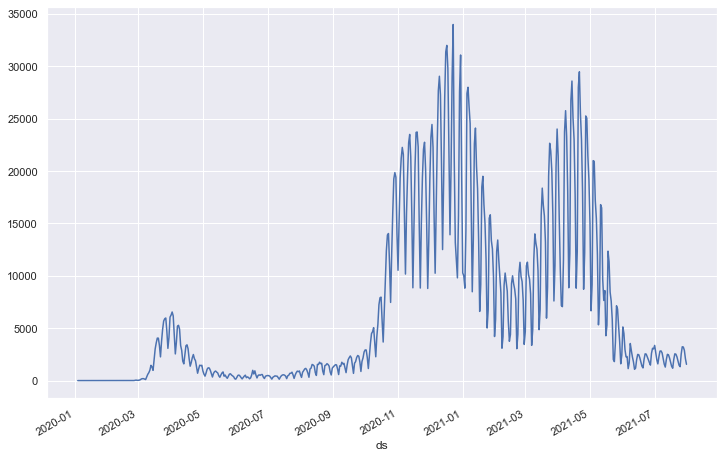

In [612]:
df_sum.y.plot(figsize=(12,8));

# How many cases will we have in Germany until the end of June 2021

In [615]:
print("According to our prediction model the cummulated number of cases will be {} by the end of July 2021".format(round(df_sum["y"].sum())))
print("That means {} will be infected by the end of July 2021".format((df_sum["y"].sum()/pop_ger)*100))

According to our prediction model the cummulated number of cases will be 3821006 by the end of July 2021
That means 4.598082201306515 will be infected by the end of July 2021


# End